In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#pip install wandb

Create a siamese network for immage classification

In [3]:
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm as tq
import matplotlib.pyplot as plt
from skimage.io import imshow
from pathlib import Path
import numpy as np
import random
import wandb

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


c:\Users\thoma\.conda\envs\deepL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

#wandb.login()

load data

In [5]:
#/content/drive/MyDrive/Colab Notebooks/efficent net/
npz = np.load('../data/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']

del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))

We have 4113 examples to work with


plot some data

In [6]:
# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def plot_image(ix):
    imshow(np.squeeze(X_train[ix,:,:,:]))#Looking at the combined channel
    plt.show()
    labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(Y_train[ix])])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


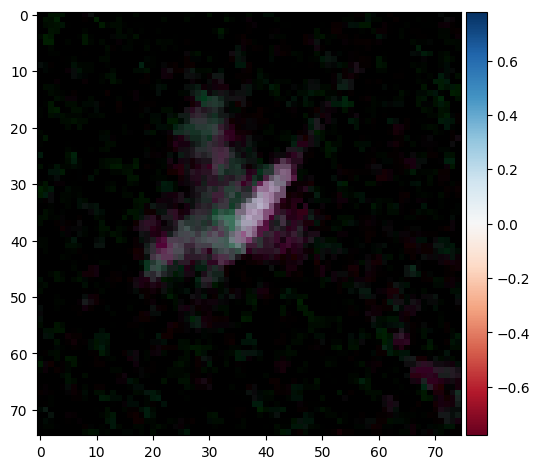

This is: Iceberg


In [7]:
plot_image(101)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


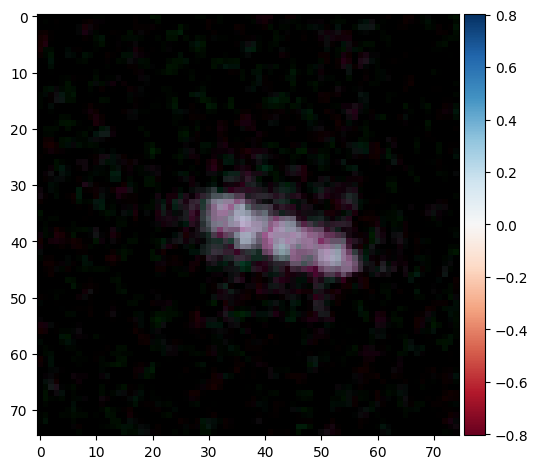

This is: Ship


In [8]:
plot_image(100)

create a base network

In [9]:

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.apply(self._init_weights)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5,7,3,padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        #self.dropout=nn.Dropout(p=0.5) 
        
        self.fc1=nn.Sequential(
            nn.Linear(2268,18),
            nn.Sigmoid())

        self.out = nn.Linear(18,1)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=0.01)
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.2)
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=0.01)
        
    def forward_once(self,inp):
        inp=self.conv(inp)
        #inp=inp.view(inp.size()[0], -1)
        #inp = self.dropout(inp) #
        inp=self.fc1(inp)
        return inp

    def forward(self, inp1, inp2):
        out1=self.forward_once(inp1)
        out2=self.forward_once(inp2)
        dis=torch.abs(out2-out1)
        out=self.out(dis)
        return out

Create the pair of images to train on

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, left_list, right_list,targets, transform):
        self.left_dat = left_list
        self.right_dat = right_list
        self.targets = targets
        self.transform = transform
        self.imag_nomr = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        left_img = self.left_dat[idx]
        right_img = self.right_dat[idx]
        targets = self.targets[idx]
        
        left_img = np.transpose(left_img,(2,0,1))
        left_img = torch.Tensor(left_img)

        right_img = np.transpose(right_img,(2,0,1))
        right_img = torch.Tensor(right_img)

        # nomalization of immages
        left_img = self.imag_nomr(left_img)
        right_img = self.imag_nomr(right_img)
                        
        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
    
        return left_img, right_img, targets




In [11]:
def crate_Pairs_data(image_list,label_list, pairs = 5):
    """

    """
    left_input = []
    right_input = []
    targets = []

    #Number of pairs per image
    pairs = pairs
    #Let's create the new dataset to train on
    for i in range(len(label_list)):
        for _ in range(pairs): 
            # compare the same immage on the left to different immages to the right
            compare_to = i 
            while compare_to == i: #Make sure it's not comparing to itself
                compare_to = random.randint(0,len(image_list)-1)

            left_img = image_list[i][0]
            right_img = image_list[compare_to][0]

            # create data sets
            left_input.append(np.array(left_img))
            right_input.append(np.array(right_img))

            if label_list[i] == label_list[compare_to]:# They are the same
                targets.append(0.)
            else:# Not the same
                targets.append(1.)
    
    return left_input,right_input,targets

In [12]:
X_index, y_index = range(X_train.shape[0]), range(Y_train.shape[0])
# test 20% 
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(X_index, y_index,
    test_size=0.2, shuffle = True, random_state = 42)

# validation 20% training 60%
X_train_index, X_val_index, y_train_index, y_val_index = train_test_split(X_train_index, y_train_index, 
    test_size=0.20, random_state= 42) # 0.25 x 0.8 = 0.2

In [13]:
len(X_train_index),len(X_val_index),len(X_test_index)


(2632, 658, 823)

Data augemtation

In [14]:
transform = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomGrayscale(0.5),
    )

Train data

In [16]:
image_list_train = np.split(X_train[X_train_index],len(X_train_index))
label_list_train = np.split(Y_train[y_train_index],len(y_train_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_train,label_list=label_list_train,pairs=5)
train_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

In [ ]:

def plot_image_pair(num_img):
    f, axarr = plt.subplots(2)
    axarr[0].imshow(np.squeeze(train_dataset.right_dat[num_img]))
    axarr[1].imshow(np.squeeze(train_dataset.left_dat[num_img]))
    plt.show()
    labels = ['equal','not equal']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(train_dataset.targets[num_img])])


Validation data

In [18]:
image_list_val = np.split(X_train[X_val_index],len(X_val_index))
label_list_val = np.split(Y_train[y_val_index],len(y_val_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_val,label_list=label_list_val,pairs=5)
validation_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

Test data

In [19]:
image_list_test = np.split(X_train[X_test_index],len(X_test_index))
label_list_test = np.split(Y_train[y_test_index],len(y_test_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_test,label_list=label_list_test,pairs=5)
test_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

In [20]:
num_workers = 2
bs = 64
# Rest of the code goes the same

train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs,shuffle=False, num_workers=num_workers)


validation_dataset_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

In [21]:
del X_train,Y_train,train_dataset,validation_dataset,image_list_train,image_list_val

train model

In [22]:
net = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 2.5e-4 )#, weight_decay = 2.5e-4 
lambda2 = lambda epoch: 0.99
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda2)

train_on_gpu = torch.cuda.is_available()
train_on_gpu

if train_on_gpu:
    net.cuda()

In [23]:
def correct_out(output,label):
    for j in range(output.size(0)):
        if (output[j]>0.5) and (label[j]==1):
            TrueNegative+=1

        elif (output[j]<0.5) and (label[j]==1):
            FalseNegative+=1
        elif (output[j]<0.5) and (label[j]==0):
            TruePositive+=1
            
        elif (output[j]<0.5) and (label[j]==1):
            FalsePositive+=1

    return TrueNegative,FalseNegative,TruePositive,FalsePositive

In [ ]:
#wandb.init(project="siamese_net",config={"learning_rate": 0.01,"architecture": "Siamese Network","dataset": "Iceberg","epochs": 10,})

In [ ]:
n_epochs = 10
lr_rate_list =[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    TN=0
    FN=0
    TP=0
    FP=0

    ###################
    #   MODEL TRAIN   #
    ###################
    net.train()
    bar = tq(train_dataset_loader, postfix={"train_loss":0.0})
    #config = wandb.config

    for img0, img1, label in bar:
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        optimizer.zero_grad()
        output = net(img0, img1)

        loss = criterion(output, label.unsqueeze(1))
        loss.backward()
        optimizer.step()


        # stats

        total = label.size(0)
        TN,FN,TP,FP= correct_out(output,label)
        correct += (TN+TP)/total

        bar.set_postfix({"Train loss":loss.item(),
        "Precision":TP / (TP + FP),"Recall":TP /(TP + FN),
        "Accuracy":(TP+TN)/(TP + TN + FN + FP),"Jaccard":TP/(TP + FN + FP),
        "correct_out":correct})


    Pr = TP / (TP + FP)
    Rec = TP /(TP + FN)
    Acc = (TP+TN)/(TP + TN + FN + FP)
    Jaccard = TP/(TP + FN + FP)
    train_metrics = {"train/loss": loss.item()/count,"train/Precision":Pr,"train/Recall":Rec,"train/Jaccard" :Jaccard, 
                       "train/accuracy": Acc}
    wandb.log({**train_metrics})

    ######################   
    #  MODEL VALIDATION  #
    ######################
    net.eval()
    del img0, img1, label, bar
    TN=0
    FN=0
    TP=0
    FP=0

    with torch.no_grad():
        bar = tq(validation_dataset_loader, postfix={"valid_loss":0.0})
        for img0, img1, label in bar:
            
            if train_on_gpu:
                img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            
            output = net(img0, img1)
            loss = criterion(output, label.unsqueeze(1))
            
            total = label.size(0)
            TN,FN,TP,FP += correct_out(output,label,correct)

            correct += (TP+TN)/total

            bar.set_postfix({"Validation loss":loss.item(),
            "Precision":TP / (TP + FP),"Recall":TP /(TP + FN),
            "Accuracy":(TP+TN)/(TP + TN + FN + FP),"Jaccard":TP/(TP + FN + FP),
            "correct_out":correct})

    Pr = TP / (TP + FP)
    Rec = TP /(TP + FN)
    Acc = (TP+TN)/(TP + TN + FN + FP)
    Jaccard = TP/(TP + FN + FP)

    val_metrics = {"val/loss": loss.item()/count,"val/Precision":Pr,"val/Recall":Rec,"val/Jaccard" :Jaccard, 
                       "val/accuracy": Acc}
    wandb.log({**val_metrics})
    
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    print("Accuracy training loss after {} epochs : {}".format(epoch, Train_acc))
    print("Average validation loss after {} epochs : {}".format(epoch, Validation_acc))


  0%|          | 0/8 [00:00<?, ?it/s, train_loss=0]

Evaluate on test set

In [ ]:
test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64,shuffle=False, num_workers=2)


In [ ]:
result = []

with torch.no_grad():
    net.eval()
    correct=0
    count=0
    correct_count=0
    #del img0, img1, label
    print("Testing...")
    bar = tq(test_dataset_loader, postfix={"Accuracy":0.0})
    for img0, img1, label in bar:
        
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        output = net(img0, img1)
        
        total = label.size(0)
        

        # check if prediction and actual label are same
        for j in range(output.size(0)):

            if (output[j]>0.5) and (label[j]==1):
                correct+=1

            elif (output[j]<0.5) and (label[j]==0):
                correct+=1
            labels = ['equal','not equal'] 
            
            case= {'predict':output[j],'real':labels[int(test_dataset_loader.dataset.targets[j])]}
            result.append(case)
 
            
        correct_count+=correct/total
        correct = 0
        count +=1 
        bar.set_postfix(ordered_dict={"Accuracy":(correct_count/count)*100})
        #imshow(torchvision.utils.make_grid(cat),'Pred : {:.2f} Label : {}'.format(prediction.item(),label.item()))   
        #imshow(torchvision.utils.make_grid(cat),'Pred : {:.2f} Label : {}'.format(output.item(),label.item()))   
print('{} correct predictions out of {}\nAccuracy : {:.2f}'.format(correct_count,count, (correct_count/count)*100))

Testing...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b980dad30>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f6b980dad30>Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

      File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

      File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in 

  0%|          | 0/65 [00:02<?, ?it/s, Accuracy=0]

52.61595394736842 correct predictions out of 65
Accuracy : 80.95


In [ ]:
result

[{'predict': tensor([-2.5185], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-2.4748], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-0.4074], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([3.8619], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([3.9886], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([-1.9732], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([1.3707], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([-1.3488], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-1.1386], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-0.6544], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-1.4126], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([2.7830], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([1.8584], device='cuda:0'), 'real': 'not equal'},
 {'predict': tensor([-1.0812], device='cuda:0'), 'real': 'equal'},
 {'predict': tensor([-1.3852], device='cuda